# Setup & Load Data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

def nice_grid():
    ''' Hàm thay đổi trạng thái hiển thị của biểu đồ '''
    plt.grid(axis='y', linestyle='--', alpha=0.7)

RAW_DIR   = Path("./ Data")
OUT_DIR   = Path("./DataAfterProcessing")
PROC_DIR  = OUT_DIR / "Processed"
STATS_DIR = OUT_DIR / "Stats"
STATS_DIR.mkdir(parents=True, exist_ok=True)

F_PRODUCTS_ENRICHED = PROC_DIR / "products_enriched.csv"
F_TX_LONG          = PROC_DIR / "transactions_long.csv"

products = pd.read_csv(F_PRODUCTS_ENRICHED)
tx_long  = pd.read_csv(F_TX_LONG)

print(f"Products shape: {products.shape}")
print(f"Transactions shape: {tx_long.shape}")

Products shape: (12877, 15)
Transactions shape: (49786, 11)


# Tổng quan dữ liệu

In [2]:
n_products = products["product_id_str"].nunique()
n_brands   = products["brand_name"].nunique()
n_cats     = products["category_name"].nunique()
n_parent   = products["parent_category_name"].replace("", np.nan).nunique()
n_bills    = tx_long["bill_id"].nunique()

print("=== TỔNG QUAN DỮ LIỆU ===")
print("Số sản phẩm:", n_products)
print("Số thương hiệu:", n_brands)
print("Số category (child):", n_cats)
print("Số parent category:", n_parent)
print("Số bill:", n_bills)

print("Top 15 parent categories by number of products:")
top_parent = (products.groupby("parent_category_name")["product_id_str"].nunique()
              .sort_values(ascending=False).head(15))
top_parent

=== TỔNG QUAN DỮ LIỆU ===
Số sản phẩm: 12877
Số thương hiệu: 1431
Số category (child): 261
Số parent category: 86
Số bill: 4430
Top 15 parent categories by number of products:


parent_category_name
Dụng Cụ Bếp, Phòng Ăn       1033
Bánh Kẹo                     615
Mì, Bún, Topokki Ăn Liền     547
Bánh Các Loại                490
Chăm Sóc Tóc                 424
Sốt, Gia Vị Các Loại         417
Làm Sạch Cơ Thể              411
Nước Ngọt                    364
Hạt, Trái Cây Sấy            317
Sữa Nước                     315
Snack, Ăn Vặt                312
Đồ Uống                      267
Rau Củ                       258
Chăm Sóc Da Mặt              244
Rượu                         238
Name: product_id_str, dtype: int64

# Basket Analysis

--- THỐNG KÊ KÍCH THƯỚC GIỎ HÀNG (Sản phẩm/Bill) ---
count    4430.00
mean       11.24
std         3.60
min         5.00
25%         8.00
50%        11.00
75%        14.00
max        22.00
Name: product_id_str, dtype: float64

- Trung bình 1 bill có: 11.24 sản phẩm
- Bill mua ít nhất: 5 sản phẩm
- Bill mua nhiều nhất: 22 sản phẩm
- 75% số bill có dưới: 14 sản phẩm


c:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


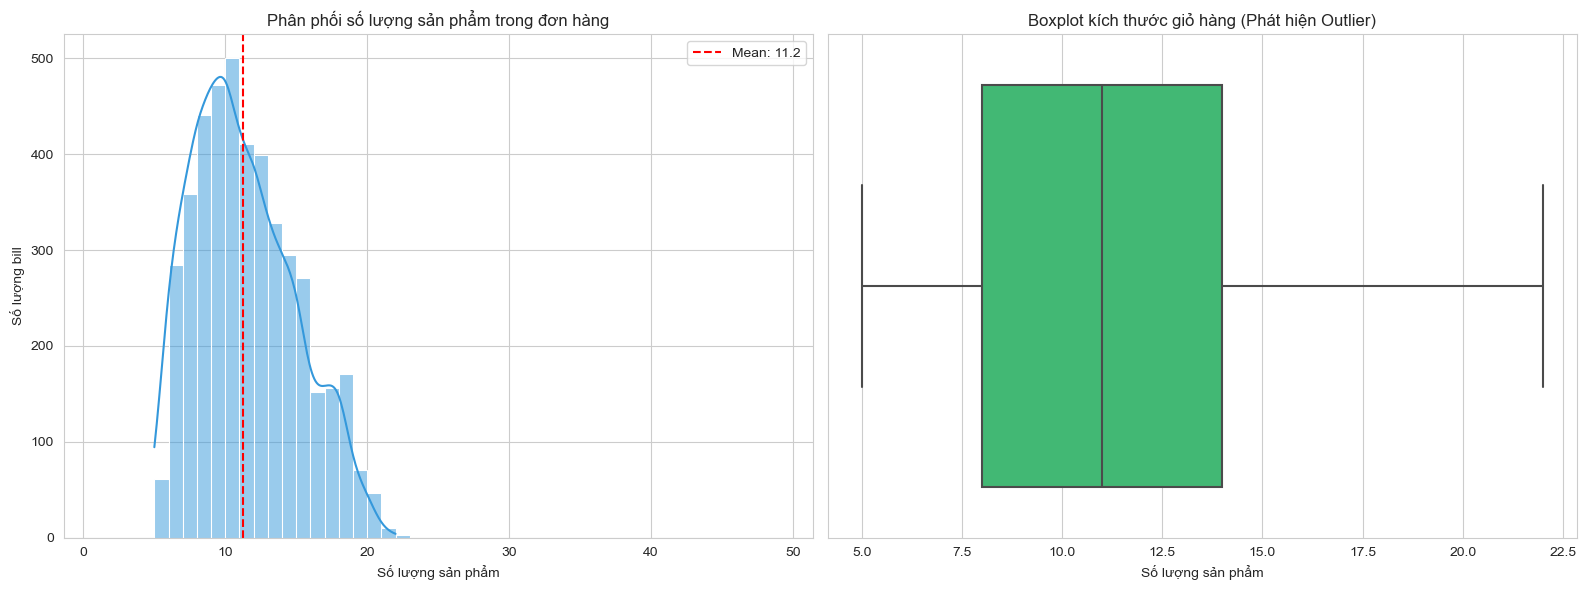

In [3]:
# --- BASKET ANALYSIS (Hành vi User) ---

# Group by bill_id để đếm số lượng sản phẩm trong mỗi bill
basket_sizes = tx_long.groupby("bill_id")['product_id_str'].count()

# Thống kê mô tả
print("--- THỐNG KÊ KÍCH THƯỚC GIỎ HÀNG (Sản phẩm/Bill) ---")
print(basket_sizes.describe().round(2))
print(f"\n- Trung bình 1 bill có: {basket_sizes.mean():.2f} sản phẩm")
print(f"- Bill mua ít nhất: {basket_sizes.min()} sản phẩm")
print(f"- Bill mua nhiều nhất: {basket_sizes.max()} sản phẩm")
print(f"- 75% số bill có dưới: {basket_sizes.quantile(0.75):.0f} sản phẩm")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Histogram phân phối
sns.histplot(basket_sizes, bins=range(1, 50), kde=True, ax=ax[0], color='#3498db')
ax[0].set_title("Phân phối số lượng sản phẩm trong đơn hàng")
ax[0].set_xlabel("Số lượng sản phẩm")
ax[0].set_ylabel("Số lượng bill")
ax[0].axvline(basket_sizes.mean(), color='red', linestyle='--', label=f'Mean: {basket_sizes.mean():.1f}')
ax[0].legend()

# Biểu đồ 2: Boxplot để xem Outlier (những bill mua sỉ cực lớn)
sns.boxplot(x=basket_sizes, ax=ax[1], color='#2ecc71')
ax[1].set_title("Boxplot kích thước giỏ hàng (Phát hiện Outlier)")
ax[1].set_xlabel("Số lượng sản phẩm")

plt.tight_layout()
plt.show()

# Product Popularity


--- THỐNG KÊ TẦN SUẤT SẢN PHẨM (Số Bill chứa sản phẩm đó) ---
count    6488.00
mean        7.67
std         8.15
min         1.00
25%         2.00
50%         4.00
75%        13.00
max        64.00
Name: count, dtype: float64

- Trung bình 1 sản phẩm xuất hiện trong: 7.67 bill
- Sản phẩm xuất hiện nhiều nhất: 64 bill
- Sản phẩm xuất hiện ít nhất: 1 bill
- Số lượng sản phẩm chỉ xuất hiện đúng 1 lần: 951 (14.66%)


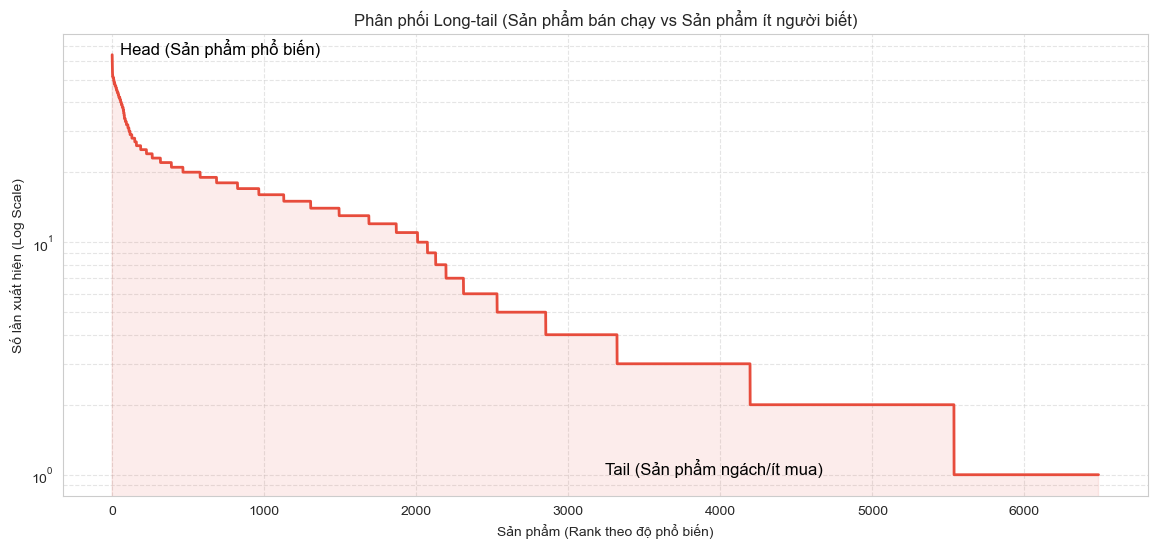

Top 10 sản phẩm xuất hiện nhiều nhất:


,product_id_str,count,product_name_vi
0,68312a85419bc51ab2ee7277,64,Cháo Ăn Liền Vifon Vị Cá Gói 50g
1,68312d4b419bc51ab2ee76ef,56,Miến Phú Hương Vị Gà Gói 53G
2,68312d66419bc51ab2ee771b,54,Phở Trộn Long Triều Bò Tái Lăn Vifon Gói 90G
3,68312a93419bc51ab2ee728e,52,Cháo Ăn Liền Ottogi Gà Dinh Dưỡng Hộp 285G
4,68312a89419bc51ab2ee727e,52,Cháo Ăn Liền Vị Rau Củ Dongwon 285g
5,68312a93419bc51ab2ee728f,51,Cháo Ăn Liền Ottogi Bào Ngư Hộp 285G
6,6831397a419bc51ab2ee8a22,51,Khăn Giấy Rút Paseo 2 Lớp Gói 220 Tờ
7,68312d66419bc51ab2ee771a,51,Phở Trộn Long Triều Hải Sản Cay Vifon Gói 90G
8,68312d45419bc51ab2ee76e5,51,Miến Ăn Liền Vị Lẩu Cay Ottogi Ly 38.1G
9,68313957419bc51ab2ee89ea,51,Khăn Bếp Đa Năng Bless You À La Vie 2 Lớp Lốc ...


In [4]:
# --- PRODUCT POPULARITY (Độ phủ Sản phẩm) ---

# Đếm số lần xuất hiện của mỗi sản phẩm trong các bill
item_counts = tx_long['product_id_str'].value_counts()

print("\n--- THỐNG KÊ TẦN SUẤT SẢN PHẨM (Số Bill chứa sản phẩm đó) ---")
print(item_counts.describe().round(2))
print(f"\n- Trung bình 1 sản phẩm xuất hiện trong: {item_counts.mean():.2f} bill")
print(f"- Sản phẩm xuất hiện nhiều nhất: {item_counts.max()} bill")
print(f"- Sản phẩm xuất hiện ít nhất: {item_counts.min()} bill")
print(f"- Số lượng sản phẩm chỉ xuất hiện đúng 1 lần: {(item_counts == 1).sum()} ({((item_counts == 1).sum()/len(item_counts)*100):.2f}%)")

# Trực quan hóa Long-tail Distribution
plt.figure(figsize=(14, 6))
y_values = item_counts.values
x_values = range(len(y_values))

plt.plot(x_values, y_values, color='#e74c3c', linewidth=2)
plt.fill_between(x_values, y_values, color='#e74c3c', alpha=0.1)

plt.title("Phân phối Long-tail (Sản phẩm bán chạy vs Sản phẩm ít người biết)")
plt.xlabel("Sản phẩm (Rank theo độ phổ biến)")
plt.ylabel("Số lần xuất hiện (Log Scale)")
plt.yscale('log') # Quan trọng: Dùng Log scale để nhìn rõ phần đuôi
plt.grid(True, which="both", ls="--", alpha=0.5)

# Annotation
plt.text(50, y_values[0], 'Head (Sản phẩm phổ biến)', fontsize=12, color='black')
plt.text(len(y_values)/2, 1, 'Tail (Sản phẩm ngách/ít mua)', fontsize=12, color='black')

plt.show()

# Lấy Top 10 sản phẩm
top_10_stats = item_counts.head(10).reset_index()

# Cột 1 là ID sản phẩm, Cột 2 là Số lượng đếm được
top_10_stats.columns = ['product_id_str', 'count']

# Lấy thông tin tên sản phẩm từ bảng products
top_10_info = products[products['product_id_str'].isin(top_10_stats['product_id_str'])][['product_id_str', 'product_name_vi']]

# Merge và hiển thị
print("Top 10 sản phẩm xuất hiện nhiều nhất:")
display(pd.merge(top_10_stats, top_10_info, on='product_id_str', how='left'))

# Category Penetration


--- THỐNG KÊ ĐỘ PHỦ NGÀNH HÀNG (Số bill chứa Category đó) ---
count     216.00
mean      169.53
std       313.61
min         1.00
25%        13.00
50%        46.00
75%       186.00
max      2310.00
Name: bill_id, dtype: float64

- Tổng số ngành hàng (Categories): 216
- Trung bình 1 Category xuất hiện trong: 169.53 bill
- Category phổ biến nhất: Bánh Snack (2310 bill)


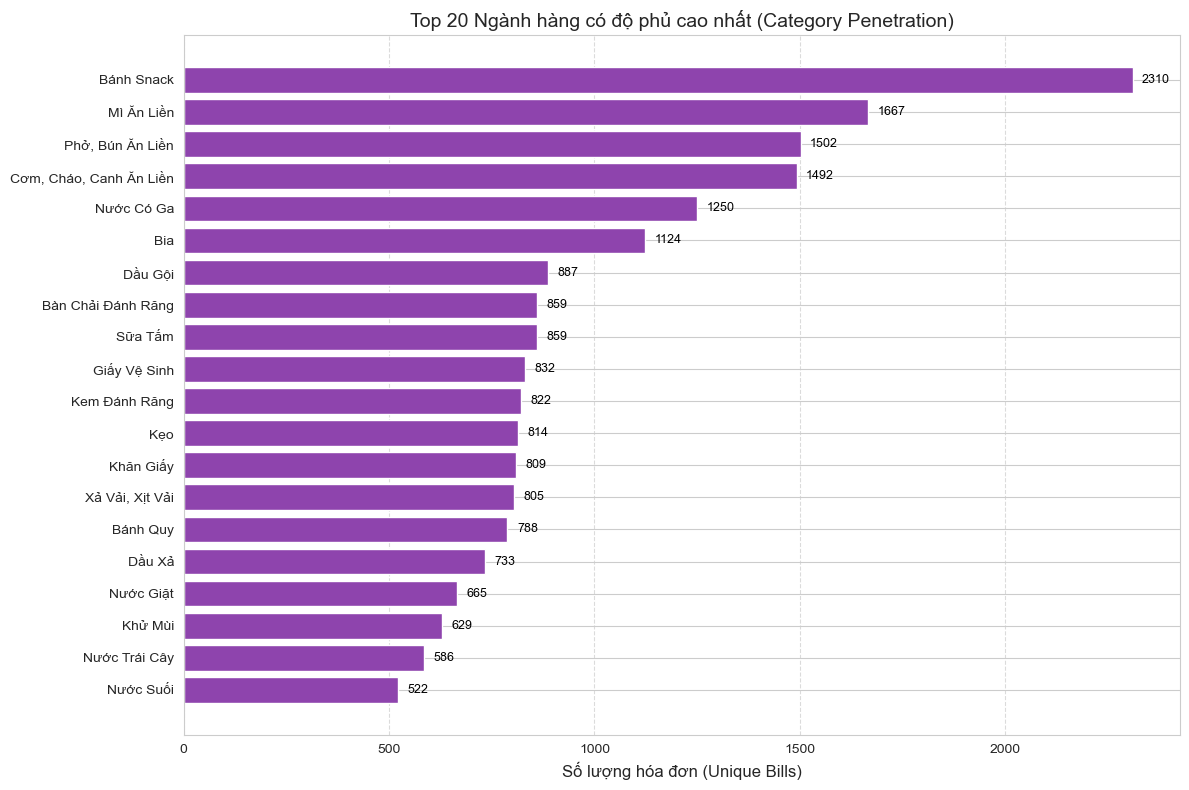

In [5]:
# --- CATEGORY PENETRATION (Độ phủ Ngành hàng) ---

# Chuyển về string, xóa khoảng trắng thừa, xử lý Null
tx_long['category_name'] = tx_long['category_name'].fillna('Unknown Category').astype(str).str.strip()

# Đếm số bill unique mà mỗi category xuất hiện
# (Logic: Trong 1 bill, dù mua 10 món thuộc 'Sữa' thì chỉ tính là 1 lần 'Sữa' xuất hiện trong bill đó)
cat_stats = tx_long.groupby('category_name')['bill_id'].nunique().sort_values(ascending=False)

print("\n--- THỐNG KÊ ĐỘ PHỦ NGÀNH HÀNG (Số bill chứa Category đó) ---")
print(cat_stats.describe().round(2))
print(f"\n- Tổng số ngành hàng (Categories): {len(cat_stats)}")
print(f"- Trung bình 1 Category xuất hiện trong: {cat_stats.mean():.2f} bill")
print(f"- Category phổ biến nhất: {cat_stats.index[0]} ({cat_stats.max()} bill)")

plt.figure(figsize=(12, 8))

# Lấy Top 20 Category phổ biến nhất
top_20_cat = cat_stats.head(20).sort_values(ascending=True)

# Cắt ngắn tên nếu quá dài (trên 50 ký tự) để biểu đồ đẹp hơn
y_labels = [name[:50] + '...' if len(name) > 50 else name for name in top_20_cat.index]

# Vẽ biểu đồ ngang
bars = plt.barh(y_labels, top_20_cat.values, color='#8e44ad')

plt.title("Top 20 Ngành hàng có độ phủ cao nhất (Category Penetration)", fontsize=14)
plt.xlabel("Số lượng hóa đơn (Unique Bills)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Thêm nhãn số liệu (Data Labels) vào cuối thanh bar
for bar in bars:
    width = bar.get_width()
    # Hiển thị số liệu ngay bên phải thanh bar
    plt.text(width + (cat_stats.max() * 0.01), 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()